In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import mdtraj as md

import torch

from snrv import Snrv

In [2]:
traj = md.load("../traj_2000_2500.dcd", top="../aib9.gro")
biasing_atom_ids = np.array([atom.index for atom in traj.topology.atoms if atom.residue.name != 'HOH'])
feat_indices = np.array([atom.index for atom in traj.topology.atoms if (atom.name == 'CA' or atom.name == 'CAY' or atom.name == 'CAT')])
pos = torch.from_numpy(traj.xyz)
box = torch.from_numpy(np.asarray([np.diag(i) for i in traj.unitcell_vectors])).view(-1, 1, 3)

In [3]:
def generate_pair_indices_from_list(index_list):
    i_list = []
    j_list = []
    for i in range(len(index_list)):
        for j in range(i + 1, len(index_list)):
            i_list.append(index_list[i])
            j_list.append(index_list[j])
    return torch.tensor(i_list), torch.tensor(j_list)

In [4]:
i_list_d, j_list_d = generate_pair_indices_from_list(feat_indices)

In [5]:
def compute_mic_dist(pos, box, i, j):
    d = pos[:, i, :] - pos[:, j, :]  # shape: [T, M, 3]
    d = d - box * torch.round(d / box)  # apply MIC
    return torch.norm(d, dim=-1)  # shape: [T, M]

In [6]:
traj_x_d = compute_mic_dist(pos, box, i_list_d, j_list_d)

In [7]:
def generate_dihedral_indices_linear(index_list):
    i_list = []
    j_list = []
    k_list = []
    l_list = []

    for n in range(len(index_list) - 3):
        i_list.append(index_list[n])
        j_list.append(index_list[n + 1])
        k_list.append(index_list[n + 2])
        l_list.append(index_list[n + 3])

    return (
        torch.tensor(i_list, dtype=torch.long),
        torch.tensor(j_list, dtype=torch.long),
        torch.tensor(k_list, dtype=torch.long),
        torch.tensor(l_list, dtype=torch.long),
    )

In [8]:
i_list_dih, j_list_dih, k_list_dih, l_list_dih = generate_dihedral_indices_linear(feat_indices)

In [9]:
def compute_mic_dihedrals(pos, box, i, j, k, l):
    # pos: [T, N, 3]
    # box: [T, 1, 3] (broadcastable)
    # i, j, k, l: [M]

    # MIC vectors
    b1 = pos[:, j, :] - pos[:, i, :]
    b1 = b1 - box * torch.round(b1 / box)

    b2 = pos[:, k, :] - pos[:, j, :]
    b2 = b2 - box * torch.round(b2 / box)

    b3 = pos[:, l, :] - pos[:, k, :]
    b3 = b3 - box * torch.round(b3 / box)

    # Normalize b2 for later
    b2_norm = torch.nn.functional.normalize(b2, dim=-1)

    # Compute normals to the planes
    n1 = torch.cross(b1, b2, dim=-1)  # plane i-j-k
    n2 = torch.cross(b2, b3, dim=-1)  # plane j-k-l

    # Normalize
    n1 = torch.nn.functional.normalize(n1, dim=-1)
    n2 = torch.nn.functional.normalize(n2, dim=-1)

    # Compute cosine and sine terms
    cos_phi = (n1 * n2).sum(dim=-1).clamp(-1.0, 1.0)
    sin_phi = (torch.cross(n1, n2, dim=-1) * b2_norm).sum(dim=-1)

    # Final torsion angle
    dihedrals = torch.atan2(sin_phi, cos_phi)  # shape: [T, M], radians

    return dihedrals

In [10]:
traj_x_dih = compute_mic_dihedrals(pos, box, i_list_dih, j_list_dih, k_list_dih, l_list_dih)

In [13]:
traj_x = torch.concat([traj_x_d, traj_x_dih], dim=1)

In [14]:
traj_x.shape

torch.Size([10000, 63])

In [19]:
input_size = traj_x.size()[1]
output_size = 3
hidden_depth = 3
hidden_size = 500
batch_norm = True
dropout_rate = 0.
lr = 1E-5
weight_decay = 0.
val_frac = 0.20
n_epochs = 75
batch_size = 500
VAMPdegree = 2
is_reversible = True
num_workers = 0

model = Snrv(input_size, output_size, hidden_depth=hidden_depth, hidden_size=hidden_size,
            batch_norm=batch_norm, dropout_rate=dropout_rate, lr=lr, weight_decay=weight_decay, 
            val_frac=val_frac, n_epochs=n_epochs, batch_size=batch_size, 
            VAMPdegree=VAMPdegree, is_reversible=is_reversible, num_workers=num_workers, device="cuda")
model = model.to("cuda")

In [20]:
lag = 1
model.fit(traj_x, lag)
model.save_model(f'snrv_{lag}.pt')

Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 73.13batch/s]


[Epoch 0]	 training loss = -1.552	 validation loss = -1.659


Epoch 1: 100%|██████████| 16/16 [00:00<00:00, 72.29batch/s]


[Epoch 1]	 training loss = -1.791	 validation loss = -1.823


Epoch 2: 100%|██████████| 16/16 [00:00<00:00, 73.57batch/s]


[Epoch 2]	 training loss = -1.950	 validation loss = -1.941


Epoch 3: 100%|██████████| 16/16 [00:00<00:00, 44.99batch/s]


[Epoch 3]	 training loss = -2.076	 validation loss = -2.036


Epoch 4: 100%|██████████| 16/16 [00:00<00:00, 68.31batch/s]


[Epoch 4]	 training loss = -2.186	 validation loss = -2.128


Epoch 5: 100%|██████████| 16/16 [00:00<00:00, 72.39batch/s]


[Epoch 5]	 training loss = -2.290	 validation loss = -2.210


Epoch 6: 100%|██████████| 16/16 [00:00<00:00, 76.09batch/s]


[Epoch 6]	 training loss = -2.370	 validation loss = -2.278


Epoch 7: 100%|██████████| 16/16 [00:00<00:00, 70.96batch/s]


[Epoch 7]	 training loss = -2.436	 validation loss = -2.341


Epoch 8: 100%|██████████| 16/16 [00:00<00:00, 70.48batch/s]


[Epoch 8]	 training loss = -2.491	 validation loss = -2.392


Epoch 9: 100%|██████████| 16/16 [00:00<00:00, 68.64batch/s]


[Epoch 9]	 training loss = -2.537	 validation loss = -2.437


Epoch 10: 100%|██████████| 16/16 [00:00<00:00, 70.92batch/s]


[Epoch 10]	 training loss = -2.574	 validation loss = -2.475


Epoch 11: 100%|██████████| 16/16 [00:00<00:00, 70.76batch/s]


[Epoch 11]	 training loss = -2.604	 validation loss = -2.506


Epoch 12: 100%|██████████| 16/16 [00:00<00:00, 71.75batch/s]


[Epoch 12]	 training loss = -2.629	 validation loss = -2.531


Epoch 13: 100%|██████████| 16/16 [00:00<00:00, 75.54batch/s]


[Epoch 13]	 training loss = -2.648	 validation loss = -2.552


Epoch 14: 100%|██████████| 16/16 [00:00<00:00, 67.34batch/s]


[Epoch 14]	 training loss = -2.665	 validation loss = -2.569


Epoch 15: 100%|██████████| 16/16 [00:00<00:00, 68.75batch/s]


[Epoch 15]	 training loss = -2.681	 validation loss = -2.584


Epoch 16: 100%|██████████| 16/16 [00:00<00:00, 45.26batch/s]


[Epoch 16]	 training loss = -2.693	 validation loss = -2.597


Epoch 17: 100%|██████████| 16/16 [00:00<00:00, 64.25batch/s]


[Epoch 17]	 training loss = -2.703	 validation loss = -2.607


Epoch 18: 100%|██████████| 16/16 [00:00<00:00, 67.62batch/s]


[Epoch 18]	 training loss = -2.710	 validation loss = -2.616


Epoch 19: 100%|██████████| 16/16 [00:00<00:00, 70.26batch/s]


[Epoch 19]	 training loss = -2.720	 validation loss = -2.625


Epoch 20: 100%|██████████| 16/16 [00:00<00:00, 76.33batch/s]


[Epoch 20]	 training loss = -2.727	 validation loss = -2.632


Epoch 21: 100%|██████████| 16/16 [00:00<00:00, 63.51batch/s]


[Epoch 21]	 training loss = -2.734	 validation loss = -2.639


Epoch 22: 100%|██████████| 16/16 [00:00<00:00, 74.36batch/s]


[Epoch 22]	 training loss = -2.742	 validation loss = -2.645


Epoch 23: 100%|██████████| 16/16 [00:00<00:00, 72.32batch/s]


[Epoch 23]	 training loss = -2.748	 validation loss = -2.650


Epoch 24: 100%|██████████| 16/16 [00:00<00:00, 71.78batch/s]


[Epoch 24]	 training loss = -2.751	 validation loss = -2.656


Epoch 25: 100%|██████████| 16/16 [00:00<00:00, 75.51batch/s]


[Epoch 25]	 training loss = -2.757	 validation loss = -2.660


Epoch 26: 100%|██████████| 16/16 [00:00<00:00, 74.85batch/s]


[Epoch 26]	 training loss = -2.761	 validation loss = -2.665


Epoch 27: 100%|██████████| 16/16 [00:00<00:00, 74.02batch/s]


[Epoch 27]	 training loss = -2.767	 validation loss = -2.668


Epoch 28: 100%|██████████| 16/16 [00:00<00:00, 75.78batch/s]


[Epoch 28]	 training loss = -2.772	 validation loss = -2.671


Epoch 29: 100%|██████████| 16/16 [00:00<00:00, 49.81batch/s]


[Epoch 29]	 training loss = -2.778	 validation loss = -2.674


Epoch 30: 100%|██████████| 16/16 [00:00<00:00, 101.31batch/s]


[Epoch 30]	 training loss = -2.778	 validation loss = -2.677


Epoch 31: 100%|██████████| 16/16 [00:00<00:00, 72.16batch/s]


[Epoch 31]	 training loss = -2.784	 validation loss = -2.680


Epoch 32: 100%|██████████| 16/16 [00:00<00:00, 69.30batch/s]


[Epoch 32]	 training loss = -2.786	 validation loss = -2.683


Epoch 33: 100%|██████████| 16/16 [00:00<00:00, 74.30batch/s]


[Epoch 33]	 training loss = -2.789	 validation loss = -2.685


Epoch 34: 100%|██████████| 16/16 [00:00<00:00, 74.40batch/s]


[Epoch 34]	 training loss = -2.794	 validation loss = -2.687


Epoch 35: 100%|██████████| 16/16 [00:00<00:00, 73.97batch/s]


[Epoch 35]	 training loss = -2.796	 validation loss = -2.690


Epoch 36: 100%|██████████| 16/16 [00:00<00:00, 70.79batch/s]


[Epoch 36]	 training loss = -2.800	 validation loss = -2.691


Epoch 37: 100%|██████████| 16/16 [00:00<00:00, 74.34batch/s]


[Epoch 37]	 training loss = -2.802	 validation loss = -2.693


Epoch 38: 100%|██████████| 16/16 [00:00<00:00, 72.11batch/s]


[Epoch 38]	 training loss = -2.806	 validation loss = -2.695


Epoch 39: 100%|██████████| 16/16 [00:00<00:00, 68.97batch/s]


[Epoch 39]	 training loss = -2.809	 validation loss = -2.697


Epoch 40: 100%|██████████| 16/16 [00:00<00:00, 68.49batch/s]


[Epoch 40]	 training loss = -2.810	 validation loss = -2.698


Epoch 41: 100%|██████████| 16/16 [00:00<00:00, 74.57batch/s]


[Epoch 41]	 training loss = -2.813	 validation loss = -2.699


Epoch 42: 100%|██████████| 16/16 [00:00<00:00, 58.23batch/s]


[Epoch 42]	 training loss = -2.815	 validation loss = -2.701


Epoch 43: 100%|██████████| 16/16 [00:00<00:00, 95.68batch/s]


[Epoch 43]	 training loss = -2.820	 validation loss = -2.701


Epoch 44: 100%|██████████| 16/16 [00:00<00:00, 62.94batch/s]


[Epoch 44]	 training loss = -2.822	 validation loss = -2.703


Epoch 45: 100%|██████████| 16/16 [00:00<00:00, 71.31batch/s]


[Epoch 45]	 training loss = -2.823	 validation loss = -2.704


Epoch 46: 100%|██████████| 16/16 [00:00<00:00, 74.77batch/s]


[Epoch 46]	 training loss = -2.826	 validation loss = -2.704


Epoch 47: 100%|██████████| 16/16 [00:00<00:00, 74.25batch/s]


[Epoch 47]	 training loss = -2.828	 validation loss = -2.705


Epoch 48: 100%|██████████| 16/16 [00:00<00:00, 66.31batch/s]


[Epoch 48]	 training loss = -2.829	 validation loss = -2.706


Epoch 49: 100%|██████████| 16/16 [00:00<00:00, 69.98batch/s]


[Epoch 49]	 training loss = -2.832	 validation loss = -2.707


Epoch 50: 100%|██████████| 16/16 [00:00<00:00, 72.54batch/s]


[Epoch 50]	 training loss = -2.835	 validation loss = -2.708


Epoch 51: 100%|██████████| 16/16 [00:00<00:00, 75.42batch/s]


[Epoch 51]	 training loss = -2.835	 validation loss = -2.710


Epoch 52: 100%|██████████| 16/16 [00:00<00:00, 69.98batch/s]


[Epoch 52]	 training loss = -2.838	 validation loss = -2.710


Epoch 53: 100%|██████████| 16/16 [00:00<00:00, 72.99batch/s]


[Epoch 53]	 training loss = -2.840	 validation loss = -2.710


Epoch 54: 100%|██████████| 16/16 [00:00<00:00, 77.53batch/s]


[Epoch 54]	 training loss = -2.844	 validation loss = -2.711


Epoch 55: 100%|██████████| 16/16 [00:00<00:00, 46.14batch/s]


[Epoch 55]	 training loss = -2.845	 validation loss = -2.711


Epoch 56: 100%|██████████| 16/16 [00:00<00:00, 72.17batch/s]


[Epoch 56]	 training loss = -2.846	 validation loss = -2.712


Epoch 57: 100%|██████████| 16/16 [00:00<00:00, 68.33batch/s]


[Epoch 57]	 training loss = -2.848	 validation loss = -2.712


Epoch 58: 100%|██████████| 16/16 [00:00<00:00, 68.31batch/s]


[Epoch 58]	 training loss = -2.849	 validation loss = -2.714


Epoch 59: 100%|██████████| 16/16 [00:00<00:00, 63.65batch/s]


[Epoch 59]	 training loss = -2.852	 validation loss = -2.713


Epoch 60: 100%|██████████| 16/16 [00:00<00:00, 72.07batch/s]


[Epoch 60]	 training loss = -2.853	 validation loss = -2.713


Epoch 61: 100%|██████████| 16/16 [00:00<00:00, 74.14batch/s]


[Epoch 61]	 training loss = -2.856	 validation loss = -2.714


Epoch 62: 100%|██████████| 16/16 [00:00<00:00, 74.87batch/s]


[Epoch 62]	 training loss = -2.857	 validation loss = -2.714


Epoch 63: 100%|██████████| 16/16 [00:00<00:00, 66.08batch/s]


[Epoch 63]	 training loss = -2.858	 validation loss = -2.714


Epoch 64: 100%|██████████| 16/16 [00:00<00:00, 68.08batch/s]


[Epoch 64]	 training loss = -2.859	 validation loss = -2.715


Epoch 65: 100%|██████████| 16/16 [00:00<00:00, 71.63batch/s]


[Epoch 65]	 training loss = -2.862	 validation loss = -2.714


Epoch 66: 100%|██████████| 16/16 [00:00<00:00, 71.42batch/s]


[Epoch 66]	 training loss = -2.862	 validation loss = -2.716


Epoch 67: 100%|██████████| 16/16 [00:00<00:00, 63.87batch/s]


[Epoch 67]	 training loss = -2.865	 validation loss = -2.716


Epoch 68: 100%|██████████| 16/16 [00:00<00:00, 44.52batch/s]


[Epoch 68]	 training loss = -2.866	 validation loss = -2.714


Epoch 69: 100%|██████████| 16/16 [00:00<00:00, 68.45batch/s]


[Epoch 69]	 training loss = -2.868	 validation loss = -2.716


Epoch 70: 100%|██████████| 16/16 [00:00<00:00, 71.43batch/s]


[Epoch 70]	 training loss = -2.868	 validation loss = -2.716


Epoch 71: 100%|██████████| 16/16 [00:00<00:00, 69.02batch/s]


[Epoch 71]	 training loss = -2.872	 validation loss = -2.716


Epoch 72: 100%|██████████| 16/16 [00:00<00:00, 72.71batch/s]


[Epoch 72]	 training loss = -2.872	 validation loss = -2.715


Epoch 73: 100%|██████████| 16/16 [00:00<00:00, 74.92batch/s]


[Epoch 73]	 training loss = -2.873	 validation loss = -2.716


Epoch 74: 100%|██████████| 16/16 [00:00<00:00, 71.25batch/s]


[Epoch 74]	 training loss = -2.875	 validation loss = -2.716


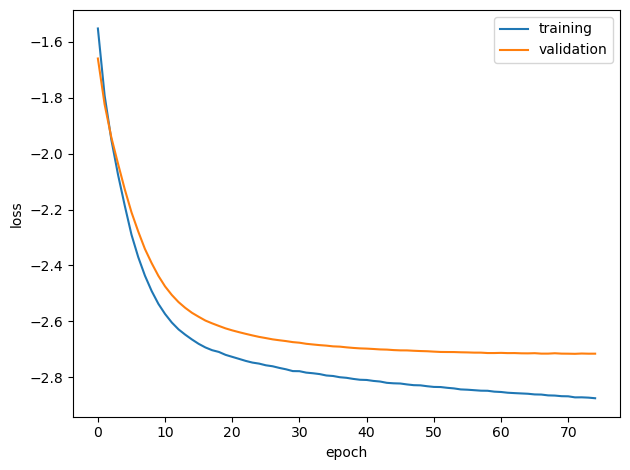

In [21]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(model.training_losses)), model.training_losses)
ax.plot(np.arange(len(model.validation_losses)), model.validation_losses)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(['training','validation'])
fig.tight_layout()

In [22]:
evecs_SRV_unbiased = model.transform(traj_x.float()).cpu().detach().numpy()

In [23]:
dataset = pd.DataFrame(evecs_SRV_unbiased, columns=["TIC0", "TIC1", "TIC2"])
px.scatter(dataset, x="TIC1", y="TIC2", width=600, height=600)

In [24]:
print(dataset.max())
print(dataset.min())

TIC0   -0.550926
TIC1    1.880856
TIC2    2.101291
dtype: float32
TIC0   -1.359628
TIC1   -1.593674
TIC2   -1.784795
dtype: float32


In [26]:
class CV(torch.nn.Module):
    def __init__(self, model, idx):
        super().__init__()
        self.model = model
        self.idx = idx
        self.register_buffer("i_list_d", i_list_d)
        self.register_buffer("j_list_d", j_list_d)
        self.register_buffer("i_list_dih", i_list_dih)
        self.register_buffer("j_list_dih", j_list_dih)
        self.register_buffer("k_list_dih", k_list_dih)
        self.register_buffer("l_list_dih", l_list_dih)

    def compute_mic_dist(self, pos, box):
        d = pos[self.i_list_d, :] - pos[self.j_list_d, :]  # shape: [T, M, 3]
        d = d - box * torch.round(d / box)  # apply MIC
        return torch.norm(d, dim=-1)  # shape: [T, M]
    
    def compute_mic_angles(self, pos, box):
        # pos: [T, N, 3]
        # box: [T, 1, 3]
        # i, j, k: [M]
        
        # MIC vector: ri - rj
        v1 = pos[self.i_list_a, :] - pos[self.j_list_a, :]  # [T, M, 3]
        v1 = v1 - box * torch.round(v1 / box)

        # MIC vector: rk - rj
        v2 = pos[self.k_list_a, :] - pos[self.j_list_a, :]
        v2 = v2 - box * torch.round(v2 / box)

        # Normalize
        v1_norm = torch.nn.functional.normalize(v1, dim=-1)
        v2_norm = torch.nn.functional.normalize(v2, dim=-1)

        # Dot product and angle
        cos_theta = (v1_norm * v2_norm).sum(dim=-1).clamp(-1.0, 1.0)
        angles = torch.acos(cos_theta)  # [T, M], in radians

        return angles
    
    def compute_mic_dihedrals(self, pos, box):
        # pos: [T, N, 3]
        # box: [T, 1, 3] (broadcastable)
        # i, j, k, l: [M]

        # MIC vectors
        b1 = pos[self.j_list_dih, :] - pos[self.i_list_dih, :]
        b1 = b1 - box * torch.round(b1 / box)

        b2 = pos[self.k_list_dih, :] - pos[self.j_list_dih, :]
        b2 = b2 - box * torch.round(b2 / box)

        b3 = pos[self.l_list_dih, :] - pos[self.k_list_dih, :]
        b3 = b3 - box * torch.round(b3 / box)

        # Normalize b2 for later
        b2_norm = torch.nn.functional.normalize(b2, dim=-1)

        # Compute normals to the planes
        n1 = torch.cross(b1, b2, dim=-1)  # plane i-j-k
        n2 = torch.cross(b2, b3, dim=-1)  # plane j-k-l

        # Normalize
        n1 = torch.nn.functional.normalize(n1, dim=-1)
        n2 = torch.nn.functional.normalize(n2, dim=-1)

        # Compute cosine and sine terms
        cos_phi = (n1 * n2).sum(dim=-1).clamp(-1.0, 1.0)
        sin_phi = (torch.cross(n1, n2, dim=-1) * b2_norm).sum(dim=-1)

        # Final torsion angle
        dihedrals = torch.atan2(sin_phi, cos_phi)  # shape: [T, M], radians

        return dihedrals

    def forward(self, positions, boxvectors):
        """The forward method returns the energy computed from positions.

        Parameters
        ----------
        positions : torch.Tensor with shape (nparticles, 3)
           positions[i,k] is the position (in nanometers) of spatial dimension k of particle i

        Returns
        -------
        potential : torch.Scalar
           The potential energy (in kJ/mol)
        """
        boxsize = boxvectors.diag()
        feat_d = self.compute_mic_dist(positions, boxsize)
        feat_dih = self.compute_mic_dihedrals(positions, boxsize)
        feats = torch.concat([feat_d, feat_dih])
        evecs = self.model.transform(feats.view(1, -1))
        CV = evecs[0][self.idx]
        return CV

model_output_1 = CV(model, 1)
model_output_2 = CV(model, 2)

torch.jit.script(model_output_1).save('cv1.pt')
torch.jit.script(model_output_2).save('cv2.pt')